# Sequential learning with CAMD

**Objective:** imagine you want to design a procedure in order to discover materials which are resistant to deformation.  Such efforts have been the subject of at least one [paper](https://pubs.acs.org/doi/10.1021/jacs.8b02717) which used machine learning to predict and verify a new superhard material, (ReWC0.8).  How would we design a method that iterated on each of its past experiments in order to improve itself?  We might want to compare various machine learning methods and their performance in a active learning procedure. This notebook describes how to do that with CAMD.

In [1]:
# !pip install camd

In [2]:
import pandas as pd

## Preprocessing data
The dataset we'll be using in the tutorial will be the elastic tensor dataset from Maarten de Jong's 2015 paper, [Charting the complete elastic properties of inorganic crystalline compounds](https://www.nature.com/articles/sdata20159).  We'll be using the [MatMiner](https://hackingmaterials.lbl.gov/matminer/) API to fetch the data, which we've written a function for in the helper code pre-installed on your SageMaker instance.  In order to make our data compatible with some machine learning functionality later on, we'll be featurizing it, also using MatMiner.  Lastly, we'll lay the groundwork for the simulation of our sequential learning procedure by separating the featurized data into **seed_data** which we will assume we have full knowledge of a-priori, and **candidate_data** which we will assume we know nothing about.

In [3]:
from matminer.datasets.convenience_loaders import load_elastic_tensor
data = load_elastic_tensor()
data = data[['formula', 'space_group', 'K_VRH', 'G_VRH']].round(1)
data = data.rename(columns={"K_VRH": "bulk_modulus", "G_VRH": "shear_modulus"})
data.head()

Fetching elastic_tensor_2015.json.gz from https://ndownloader.figshare.com/files/13220603 to /Users/josephmontoya/miniconda3/envs/camd/lib/python3.9/site-packages/matminer/datasets/elastic_tensor_2015.json.gz


Fetching https://ndownloader.figshare.com/files/13220603 in MB: 1.1182079999999999MB [00:00, 162.60MB/s]                


,formula,space_group,bulk_modulus,shear_modulus
0,Nb4CoSi,124,194.3,97.1
1,Al(CoSi)2,164,175.4,96.3
2,SiOs,221,295.1,130.1
3,Ga,63,49.1,15.1
4,SiRu2,62,256.8,101.9


In [4]:
# Sort the data and inspect again, these are the highest bulk modulus materials
# roughly equivalent to the hardest
data = data.sort_values('bulk_modulus', ascending=False)
data.head()

,formula,space_group,bulk_modulus,shear_modulus
1015,C,194,435.7,522.9
853,Os,194,401.3,258.7
413,WC,187,385.2,279.0
1103,Re,194,365.1,173.1
726,Ir3W,194,351.3,193.3


In [5]:
# Sort the data and inspect again, these are the lowest bulk modulus materials
# roughly equivalent to the softest
data.tail()

,formula,space_group,bulk_modulus,shear_modulus
909,Ba,194,8.0,3.4
224,Na,229,7.5,3.2
1016,CsI,225,7.4,3.9
957,Hg,229,7.2,2.7
992,CsBr,225,6.5,4.6


In [6]:
## Generate magpie features
from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition

data['composition'] = data['formula'].apply(Composition)
featurizer = ElementProperty.from_preset("magpie")
featurized_data = featurizer.featurize_dataframe(data, 'composition')

ElementProperty:   0%|          | 0/1181 [00:00<?, ?it/s]

In [7]:
featurized_data.head()

,formula,space_group,bulk_modulus,shear_modulus,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
1015,C,194,435.7,522.9,(C),6.0,6.0,0.0,6.00,0.000,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
853,Os,194,401.3,258.7,(Os),76.0,76.0,0.0,76.00,0.000,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
413,WC,187,385.2,279.0,"(W, C)",6.0,74.0,68.0,40.00,34.000,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,211.5,17.5,194.0
1103,Re,194,365.1,173.1,(Re),75.0,75.0,0.0,75.00,0.000,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
726,Ir3W,194,351.3,193.3,"(Ir, W)",74.0,77.0,3.0,76.25,1.125,...,0.0,0.0,0.0,0.0,225.0,229.0,4.0,226.0,1.5,225.0


Here we partition the data by choosing every other member of our known data for the seed data and the remainder for our candidate data.  Note that this partitioning can have a **significant** impact on how the sequential learning procedure progresses, just as test-train splits can in conventional machine learning. As an exercise, you might try seeing how the notebook compares if you use the alternative commented option where the seed is the bottom half of the dataset.

In [8]:
# Partition data into seed and candidate data
k_seed_data = featurized_data.iloc[::2]
k_candidate_data = featurized_data.iloc[1::2]
k_candidate_data.drop(['bulk_modulus', 'shear_modulus'], axis=1)

,formula,space_group,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
853,Os,194,(Os),76.0,76.0,0.0,76.00,0.000,76.0,57.0,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
1103,Re,194,(Re),75.0,75.0,0.0,75.00,0.000,75.0,54.0,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
571,MoC,187,"(Mo, C)",6.0,42.0,36.0,24.00,18.000,6.0,50.0,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,211.5,17.5,194.0
139,MoIr3,194,"(Mo, Ir)",42.0,77.0,35.0,68.25,13.125,77.0,50.0,...,0.0,0.0,0.0,0.0,225.0,229.0,4.0,226.0,1.5,225.0
725,IrW,51,"(Ir, W)",74.0,77.0,3.0,75.50,1.500,74.0,51.0,...,0.0,0.0,0.0,0.0,225.0,229.0,4.0,227.0,2.0,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,Sr,229,(Sr),38.0,38.0,0.0,38.00,0.000,38.0,8.0,...,0.0,0.0,0.0,0.0,225.0,225.0,0.0,225.0,0.0,225.0
564,KI,225,"(K, I)",19.0,53.0,34.0,36.00,17.000,19.0,3.0,...,0.0,0.0,0.0,0.0,64.0,229.0,165.0,146.5,82.5,64.0
10,Na,194,(Na),11.0,11.0,0.0,11.00,0.000,11.0,2.0,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0
224,Na,229,(Na),11.0,11.0,0.0,11.00,0.000,11.0,2.0,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0


In [9]:
# Alternative: choose bottom half
# half = int(len(featurized_data) / 2)
# k_seed_data = featurized_data.iloc[half:]
# k_candidate_data = featurized_data.iloc[:half]
# k_candidate_data.drop(['bulk_modulus', 'shear_modulus'], axis=1)

# Alternative: choose randomly
# half = int(len(featurized_data) / 2)
# k_seed_data = featurized_data.sample(half)
# k_candidate_data = featurized_data.loc[~k_seed_data]
# k_candidate_data.drop(['bulk_modulus', 'shear_modulus'], axis=1)

In [10]:
# test to ensure no overlap
assert not set(k_seed_data.index).intersection(k_candidate_data.index)  

### Agents
In CAMD, Hypothesis *Agents* are python objects which select candidates on which to perform experiments.  Almost all of the "AI" components, including ML algorithms, simpler regression, and even random selection, within CAMD are contained in logic implemented within Agents.  


To implement a CAMD-compatible Agent, we use the *HypothesisAgent* abstract class, which basically will issue an error if we don't fulfill all of the things we need to in order to ensure that our Agent is compatible with the sequential learning process implemented in a CAMD *Campaign* (more on Campaigns later).

In [11]:
from camd.agent.base import HypothesisAgent
from sklearn.linear_model import LinearRegression

def get_magpie_features(dataframe):
    magpie_columns = [column for column in dataframe 
                      if column.startswith("MagpieData")]
    return dataframe[magpie_columns]

In [12]:
class LinearHardnessAgent(HypothesisAgent):
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit on known data
        x_known = get_magpie_features(seed_data)
        y_known = seed_data['bulk_modulus']
        regressor = LinearRegression()
        regressor.fit(x_known, y_known)
        
        # Predict unknown data
        x_unknown = get_magpie_features(candidate_data)
        y_predicted = regressor.predict(x_unknown)
        
        # Pick top 5 candidates
        candidate_data['bulk_modulus_pred'] = y_predicted
        candidate_data = candidate_data.sort_values(
            'bulk_modulus_pred', ascending=False)
        top_candidates = candidate_data.head(5)
        return top_candidates

Let's play with the Agent a bit to see what it recommends.

In [13]:
lh_agent = LinearHardnessAgent()
hypotheses = lh_agent.get_hypotheses(k_candidate_data, k_seed_data)
hypotheses[['formula', 'bulk_modulus', 'bulk_modulus_pred']]

<ipython-input-12-106a9625b9ae>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_data['bulk_modulus_pred'] = y_predicted


,formula,bulk_modulus,bulk_modulus_pred
853,Os,401.3,367.238820
571,MoC,349.8,358.426101
1148,W,303.9,350.504942
1103,Re,365.1,335.387171
55,TaC,323.9,328.280252


In [14]:
data.head(10)

,formula,space_group,bulk_modulus,shear_modulus,composition
1015,C,194,435.7,522.9,(C)
853,Os,194,401.3,258.7,(Os)
413,WC,187,385.2,279.0,"(W, C)"
1103,Re,194,365.1,173.1,(Re)
726,Ir3W,194,351.3,193.3,"(Ir, W)"
571,MoC,187,349.8,239.8,"(Mo, C)"
7,Ir,225,346.3,216.5,(Ir)
139,MoIr3,194,337.0,187.7,"(Mo, Ir)"
919,W2C,162,335.8,165.7,"(W, C)"
725,IrW,51,334.2,182.8,"(Ir, W)"


### Preset agents
To implement the linear hardness agent more simply, we can use some pre-built agents
that will use simple logic to select the maximum prediction by a machine learning model.

In [15]:
# Regressor presets
from camd.agent.generic import RegressorAgent
n_query = 3
linear_agent = RegressorAgent.from_linear(
    features=featurizer.feature_labels(), 
    target='bulk_modulus',
    n_query=n_query
)
rf_agent = RegressorAgent.from_random_forest(
    features=featurizer.feature_labels(),
    target='bulk_modulus',
    n_query=n_query
)
mlp_agent = RegressorAgent.from_mlp(
    features=featurizer.feature_labels(),
    target='bulk_modulus',
    n_query=n_query
)

In [16]:
# Generic Model preset
from sklearn.svm import SVR
svr = SVR()
svr_agent = RegressorAgent(
    model=svr,
    features=featurizer.feature_labels(),
    target='bulk_modulus',
    n_query=n_query
)

In [17]:
### Test agent here
print(linear_agent.get_hypotheses(featurized_data, featurized_data)[['formula', 'bulk_modulus']])
print(rf_agent.get_hypotheses(featurized_data, featurized_data)[['formula', 'bulk_modulus']])
print(mlp_agent.get_hypotheses(featurized_data, featurized_data)[['formula', 'bulk_modulus']])
print(svr_agent.get_hypotheses(featurized_data, featurized_data)[['formula', 'bulk_modulus']])

    formula  bulk_modulus
413      WC         385.2
571     MoC         349.8
853      Os         401.3
     formula  bulk_modulus
853       Os         401.3
413       WC         385.2
1103      Re         365.1
     formula  bulk_modulus
919      W2C         335.8
455      W2C         334.2
1045     W2C         333.4
    formula  bulk_modulus
725     IrW         334.2
726    Ir3W         351.3
968    Nb2C         227.7


In [18]:
data.head(20)

,formula,space_group,bulk_modulus,shear_modulus,composition
1015,C,194,435.7,522.9,(C)
853,Os,194,401.3,258.7,(Os)
413,WC,187,385.2,279.0,"(W, C)"
1103,Re,194,365.1,173.1,(Re)
726,Ir3W,194,351.3,193.3,"(Ir, W)"
571,MoC,187,349.8,239.8,"(Mo, C)"
7,Ir,225,346.3,216.5,(Ir)
139,MoIr3,194,337.0,187.7,"(Mo, Ir)"
919,W2C,162,335.8,165.7,"(W, C)"
725,IrW,51,334.2,182.8,"(Ir, W)"


## Experiments

In CAMD, *Experiments* are objects that are used to generate new data corresponding to the output of the *Agent.get_hypotheses* method.  In other words, *Agents* pick the candidates on which you want to do experiments, and *Experiments* actually do those experiments.  As of today, only two experiments are implemented in CAMD, one of which is a AWS-based density functional theory computation of an input crystal structure.  The other, which we'll demonstrate below, is an *after-the-fact sampler*, which basically fetches the result of an experiment we already did that corresponds to the input.

Why is the ATFSampler useful?  We'll discuss simulation in more detail in a bit, but let's just say we use the ATFSampler to help us evaluate the performance of an Agent when we're trying to pick which agent is the best!

In [19]:
from camd.experiment.base import ATFSampler

In [20]:
k_atf_experiment = ATFSampler(dataframe=featurized_data)

Note that experiments are *stateful* meaning that their state is explicitly controlled by the user using the `submit` method.  When a new set of experiments are submitted, the previous experiments are appended to an internal history attribute and the new ones are set as the current experiments.

In [21]:
k_atf_experiment.submit(hypotheses)
results = k_atf_experiment.get_results()
results

,formula,space_group,bulk_modulus,shear_modulus,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
853,Os,194,401.3,258.7,(Os),76.0,76.0,0.0,76.0,0.0,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
571,MoC,187,349.8,239.8,"(Mo, C)",6.0,42.0,36.0,24.0,18.0,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,211.5,17.5,194.0
1148,W,229,303.9,147.3,(W),74.0,74.0,0.0,74.0,0.0,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0
1103,Re,194,365.1,173.1,(Re),75.0,75.0,0.0,75.0,0.0,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
55,TaC,225,323.9,214.6,"(Ta, C)",6.0,73.0,67.0,39.5,33.5,...,0.0,0.0,0.0,0.0,194.0,229.0,35.0,211.5,17.5,194.0


## Analyzers

**Analyzers** are a bit tricky to explain because they're not necessary for every sequential learning process.  We're not going to spend much time on them here other than to say that, after you've performed an experiment, sometimes you want to postprocess the data in order to summarize the results of the current iteration and to augment the **seed data** which is being used to provide the **Agent** with the information it needs to make its next decision on which candidates to select for further experiments. Analyzers act on "campaigns", which are effectively state machines for the iterative loop between the agent and experiments.

In [22]:
from camd.analysis import AnalyzerBase

In [23]:
# Here's an example of an analyzer
class BulkModulusAnalyzer(AnalyzerBase):
    def analyze(self, campaign):
        new_experimental_results = campaign.experiment.get_results()
        new_seed = pd.concat(
            [campaign.seed_data, new_experimental_results],
        axis=0)
        # Create a summary
        average_new_bulk_modulus = new_experimental_results.bulk_modulus.mean()
        average_dataset_bulk_modulus = new_seed.bulk_modulus.mean()
        new_result_ranks = new_seed.bulk_modulus.rank(pct=True).loc[
            new_experimental_results.index
        ]
        summary = pd.DataFrame({
            "average_new_bulk_modulus": [average_new_bulk_modulus],
            "average_dataset_bulk_modulus": [average_dataset_bulk_modulus],
            "average_rank": [new_result_ranks.mean()]
        })
        return summary

In [24]:
# Here's invoking a generic analyzer
from camd.analysis import GenericMaxAnalyzer, GenericATFAnalyzer
k_analyzer = GenericMaxAnalyzer(threshold=275.0, target='bulk_modulus')

## Data, Campaigns, and Simulations

Now that we've got all of the building blocks in place, let's try putting everything together!

In [25]:
import os, shutil
from monty.os import cd
from camd.campaigns.base import Campaign
# Set up folders
shutil.rmtree(os.path.join(os.getcwd(), "agent_comp"), ignore_errors=True)
# Reinitialize experiment to clear history
k_atf_experiment = ATFSampler(dataframe=featurized_data)
campaigns = []
for n, agent in enumerate([linear_agent, rf_agent, mlp_agent, svr_agent]):
    path = os.path.join(os.getcwd(), "agent_comp", str(n))
    os.makedirs(path)
    campaign = Campaign(
        candidate_data=k_candidate_data, 
        seed_data=k_seed_data,
        agent=agent,
        experiment=k_atf_experiment,
        analyzer=k_analyzer,
        path=path
    )
    campaign.auto_loop(initialize=True)
    campaigns.append(campaign)

Campaign initialization state: Agent RegressorAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/analysis.py:91: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:167: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:172: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Campaign 0 state: Agent RegressorAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results


Campaign 9 state: Agent RegressorAgent hypothesizing
Campaign 9 state: Running experiments
  Waiting for next round ...
Iteration: 10
Campaign 10 state: Getting new results
Campaign 10 state: Analyzing results
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/analysis.py:91: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:167: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:172: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Campaign 10 state: Agent RegressorAgent hypothesizing
Campaign 10 state: Running experiments
  Waiting for next round ...
Finalizing campaign.
Campaign 

Campaign 8 state: Running experiments
  Waiting for next round ...
Iteration: 9
Campaign 9 state: Getting new results
Campaign 9 state: Analyzing results
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/analysis.py:91: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:167: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:172: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Campaign 9 state: Agent RegressorAgent hypothesizing
Campaign 9 state: Running experiments
  Waiting for next round ...
Iteration: 10
Campaign 10 state: Getting new results
Campaign 10 state: Analyzing result

Campaign 6 state: Analyzing results
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/analysis.py:91: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:167: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:172: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Campaign 6 state: Agent RegressorAgent hypothesizing
Campaign 6 state: Running experiments
  Waiting for next round ...
Iteration: 7
Campaign 7 state: Getting new results
Campaign 7 state: Analyzing results
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/analysis.py:91: FutureWarning:The frame.append method is de

Campaign 4 state: Analyzing results
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/analysis.py:91: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:167: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/campaigns/base.py:172: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Campaign 4 state: Agent RegressorAgent hypothesizing
Campaign 4 state: Running experiments
  Waiting for next round ...
Iteration: 5
Campaign 5 state: Getting new results
Campaign 5 state: Analyzing results
 /Users/josephmontoya/PycharmProjects/camd/camd_public/camd/analysis.py:91: FutureWarning:The frame.append method is de

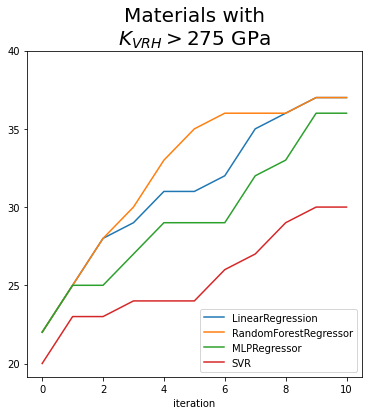

In [39]:
# Pull up some results
from matplotlib import pyplot as plt
plt.subplot(1, 1, 1)
ax = plt.gca()
for campaign in campaigns:
    campaign.history.score.plot(
        ax=ax, label=campaign.agent.model.__class__.__name__)
ax.legend(loc='lower right')
ax.set_xlabel("iteration")
ax.set_title("Materials with\n$K_{VRH} > 275$ GPa", rotation=0, fontsize=20)
ax.set_yticks(range(20, 41, 5))
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)

## Final thoughts
There's a lot more that we can do to improve our postprocessing analysis of how well the campaign proceeded, but this should get you started.  A few exercises you might find interesting to try:

* Test more regressors from scikit learn, this [documentation of their supervised learning methods](https://scikit-learn.org/stable/supervised_learning.html) points to many of them.
* Test the agent on using multiple random seeds and determine the spread on discovery rate.
* Develop an explore/exploit strategy where you choose some candidates from the regressor prediction and some randomly.
* Try different datasets, see the datasets folder or the [matminer datasets documentation](https://hackingmaterials.lbl.gov/matminer/dataset_summary.html).
* Try different featurizers, see [the matminer featurizer documentation](https://hackingmaterials.lbl.gov/matminer/featurizer_summary.html)

## Glossary
* **Agent** - decision making object in camd, must implement `get_hypotheses` in order to work properly in the loop
* **Experiment** - object which performs some action in order to determine unknowns about an input dataset
* **Analyzer** - object which acts on the campaign to summarize the results of an iteration
* **seed_data** - Data which is "known" either before the start of a given **Campaign** or prior to any iteration.  Is used to inform the **Agent** of the data it should be using to make a decision about how to select from the **Candidate data**.
* **candidate_data** - data which represents the information about the set of "unknowns" at a given point of time for a **Campaign**.
* **Campaign** - the iterative procedure by which an **Agent** suggests experiments from the **candidate data**, the **Experiment** performs them, the **Analyzer** analyzes the state and feeds a new **seed data** and set of **candidate data** back to the **Agent** to start a new iteration. 